In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_provider import IBMProvider
from qiskit import QuantumCircuit, transpile
from mitiq.zne.scaling import fold_gates_at_random, fold_all, fold_global

In [218]:
def prepare_correlated(env,n=2):
    yield cirq.H(env[0])
    yield cirq.CNOT(env[0],env[1])
    yield cirq.CNOT(env[1],env[2])

def collide(env,sys,theta):
    yield cirq.CNOT(env,sys)
    yield cirq.rz(rads=2*theta).on(sys)
    yield cirq.CNOT(env,sys)

def collision_pattern_correlated(env,sys,n,theta):
    for i in range(n):
        yield from collide(env[1],sys,theta)

def meas_coherence(sys):
    yield cirq.H(sys)
    yield cirq.measure(sys, key = 'answer')

def collision_circuit(env,sys,n,theta):
    yield cirq.H(sys)
    yield from prepare_correlated(env,n)
    yield from collision_pattern_correlated(env,sys,n,theta)
    yield from meas_coherence(sys)

In [160]:
@cirq.transformer
class SubstituteGate:
    """Transformer to substitute `source` gates with `target` in the input circuit."""

    def __init__(self, source, target):
        self._source = source
        self._target = target

    def __call__(self, circuit, *, context=None):
        batch_replace = []
        for i, op in circuit.findall_operations(lambda op: op.gate == self._source):
            batch_replace.append((i, op, self._target.on(*op.qubits)))
        transformed_circuit = circuit.unfreeze(copy=True)
        transformed_circuit.batch_replace(batch_replace)
        return transformed_circuit

substitute_h_inv = SubstituteGate(cirq.H**-1.0,cirq.H)
substitute_cnot_inv = SubstituteGate(cirq.CNOT**-1.0,cirq.CNOT)

In [367]:
provider = IBMProvider()
backend = provider.get_backend('ibm_kyoto')

In [207]:
initial_layout = [40,42,41,53]

In [408]:
n = 15
g = 1
tau = np.pi/6
t = np.array(list(range(1,n+1)))*tau
theta = g*tau

def corrfunc(time):
    return (np.cos(time)**2-np.sin(time)**2)/2

sys = cirq.LineQubit(0)
env = cirq.LineQubit.range(1,4)
repcnt = 1024

In [346]:
scale_factors = [1,3,5,7]
depth = 7

In [409]:
circ_list = []
for scale_factor in scale_factors:
    for i in range(1,n+1):
        circuit = cirq.Circuit(collision_circuit(env,sys,i,theta))
        circuit_folded = fold_gates_at_random(circuit,scale_factor)
        circuit_transformed = substitute_cnot_inv(substitute_h_inv(circuit_folded))
        circuit_qiskit = QuantumCircuit.from_qasm_str(circuit_transformed.to_qasm())
        transpiled_circuit = transpile(circuit_qiskit,backend=backend,optimization_level=0,initial_layout=initial_layout)
        circ_list.append(transpiled_circuit)

<h2>Circuit depth scaling with number of collisions:</h2>

In [350]:
circ_depth_col = [[],[]]
for i in range(1,n+1):
    circuit = cirq.Circuit(collision_circuit(env,sys,i,theta))
    circuit_qiskit = QuantumCircuit.from_qasm_str(circuit.to_qasm())
    transpiled_circuit = transpile(circuit_qiskit,backend=backend,optimization_level=0,initial_layout=initial_layout)
    circ_depth_col[0].append(len(circuit))
    circ_depth_col[1].append(transpiled_circuit.depth())

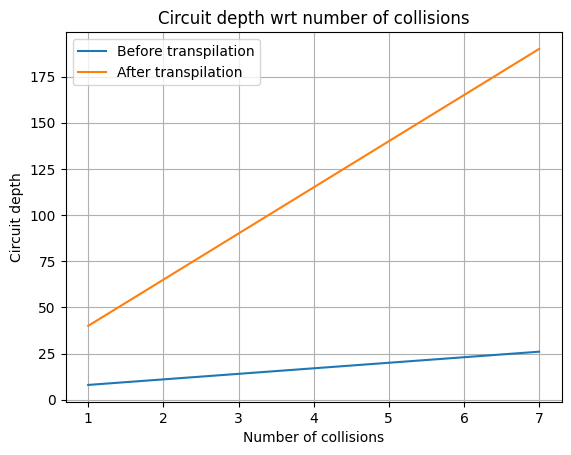

In [351]:
plt.plot(list(range(1,n+1)),circ_depth_col[0],label='Before transpilation')
plt.plot(list(range(1,n+1)),circ_depth_col[1],label='After transpilation')
plt.title('Circuit depth wrt number of collisions')
plt.xlabel('Number of collisions')
plt.ylabel('Circuit depth')
# plt.yticks(np.linspace(0,550,num=12))
plt.xticks(list(range(1,n+1)))
plt.legend()
plt.grid()
plt.show()

<h2>Circuit depth scaling plot:</h2>

In [354]:
from scipy.stats import linregress
from scipy.optimize import curve_fit
def cfit(x,a,b):
    return a*x+b
circ_depth = [circuit.count_ops()['ecr'] for circuit in circ_list]
popt,pcov = curve_fit(cfit,scale_factors,circ_depth)

C:\users\mainak\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[ 1.60000000e+01 -2.19557705e-12] [[inf inf]
 [inf inf]]


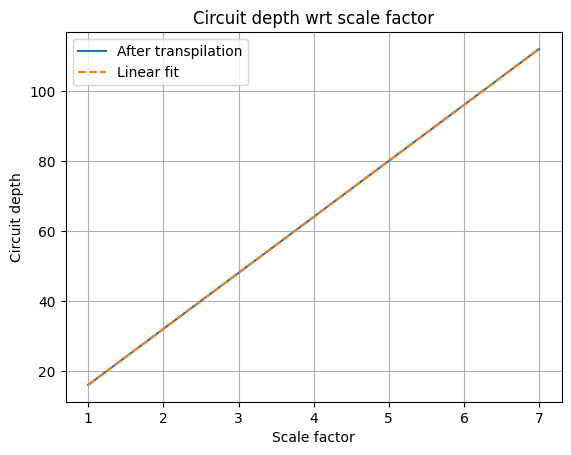

In [355]:
print(popt,pcov)
plt.plot(scale_factors,circ_depth,label='After transpilation')
plt.plot(scale_factors,popt[0]*np.array(scale_factors)+popt[1],linestyle='--',label='Linear fit')
plt.title('Circuit depth wrt scale factor')
plt.xlabel('Scale factor')
plt.ylabel('Circuit depth')
plt.legend()
plt.grid()
plt.show()

<h2>Running job:</h2>

In [411]:
with open('./Jobs/8.txt','x') as job_id_file:
        job = backend.run(circ_list,shots=repcnt)   #Run job
        job_id_file.write(job.job_id()+'\n')    #Write to file
        print('Submitted job with job id '+job.job_id())

print('All complete.')

Submitted job with job id cnspnwfye0eg008awj20
All complete.


In [40]:
def return_counts(job_id,n):
    counts = None
    job = provider.backend.retrieve_job(job_id.strip())
    if not job.done():
        print(job_id.strip()+' is not complete') # to avoid silent fail
        return counts
    results = job.result()
    counts = results.get_counts()
    res = np.zeros(shape=(n,2))
    for i in range(n):
        cnt = counts[i]
        res[i][0] += cnt.get('0',0)
        res[i][1] += cnt.get('1',0)

    return res.tolist()

In [412]:
def return_counts_scaled(job_id,n,sf,shots):
    counts = None
    job = provider.backend.retrieve_job(job_id.strip())
    if not job.done():
        print(job_id.strip()+' is not complete') # to avoid silent fail
        return counts
    results = job.result()
    counts = results.get_counts()
    res = np.zeros(shape=(n,sf))
    for j in range(sf):
        for i in range(n):
            cnt = counts[j*n+i]
            res[i][j] += 0.5-cnt.get('1',0)/shots

    return res

In [425]:
job_id = 'cnspnwfye0eg008awj20'
res = return_counts_scaled(job_id,n,len(scale_factors),repcnt)

In [457]:
from mitiq.zne import inference
def mitigate(scale_factors,exp_vals):
    mit_val,std_dev,opt_par,cov_mat,model = inference.RichardsonFactory.extrapolate(scale_factors,exp_vals,full_output=True)
    print(f'Standard deviation from linear fit is {std_dev}. Value is {mit_val}.')
    return mit_val

In [467]:
res_mit = [mitigate(scale_factors,exp_vals) for exp_vals in res]
res_unmit = [exp_vals[0] for exp_vals in res]

Standard deviation from linear fit is None. Value is 0.21569824218750006.
Standard deviation from linear fit is None. Value is -0.30126953124999983.
Standard deviation from linear fit is None. Value is -0.48956298828125033.
Standard deviation from linear fit is None. Value is -0.24670410156250033.
Standard deviation from linear fit is None. Value is 0.18664550781250044.
Standard deviation from linear fit is None. Value is 0.5180664062499994.
Standard deviation from linear fit is None. Value is 0.40820312499999845.
Standard deviation from linear fit is None. Value is -0.31451416015624956.
Standard deviation from linear fit is None. Value is -0.4160156250000005.
Standard deviation from linear fit is None. Value is -0.3093872070312487.
Standard deviation from linear fit is None. Value is 0.2022094726562511.
Standard deviation from linear fit is None. Value is 0.39520263671875056.
Standard deviation from linear fit is None. Value is 0.2699584960937493.
Standard deviation from linear fit is

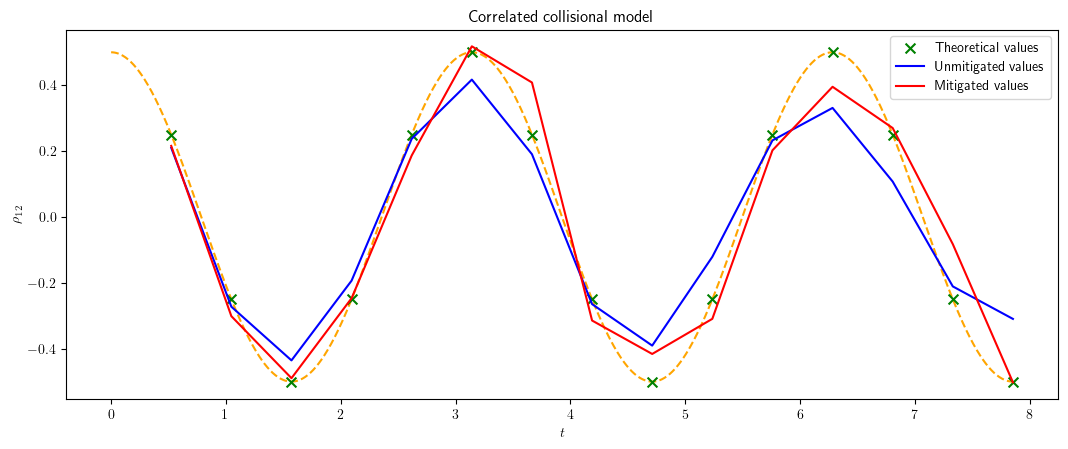

In [468]:
plt.rcParams['text.usetex'] = True
t_pl = (np.array(list(range(1,n+1)))*tau)
x_ax = np.linspace(0,t_pl[-1],num=1000)
plt.plot(x_ax,corrfunc(x_ax),linestyle='--',c='orange',zorder=0)
plt.scatter(t_pl,corrfunc(t_pl),s=50,label='Theoretical values',marker='x',c='green',zorder=1)
plt.plot(t_pl,res_unmit,label='Unmitigated values',c='blue',zorder=2)
plt.plot(t_pl,res_mit,label='Mitigated values',c='red',zorder=3)
plt.xlabel(r'$t$')
plt.ylabel(r'$\rho_{12}$')
plt.title(r'Correlated collisional model')
plt.legend()
plt.gcf().set_size_inches((12.8,4.8))
plt.show()